# Question No. 1: (Showing data)

### i. How many training and test examples are there? You can use np.loadtxt for this purpose. Show at least 10 randomly selected objects of each class using plt.matshow. 

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
import warnings
warnings.filterwarnings('ignore')

In [44]:
xtrain = np.loadtxt("Xtrain.csv")
ytrain = np.loadtxt("Ytrain.csv")
xtest = np.loadtxt("Xtest.csv")

##### Total Number of Training and Test Examples

In [46]:
xtrain_count= len(xtrain) 
# ytrain_count= len(ytrain)
xtest_count=len(xtest)
print("Total number of training examples: ",xtrain_count)
print("Total number of testing examples: ",xtest_count)

Total number of training examples:  3000
Total number of testing examples:  3000


In [4]:
# Creating a DataFrame to store both labels and images
df = pd.DataFrame({'label': ytrain, 'images': list(xtrain)})

In [5]:
# fetching 10 random samples of both (positive and negative) classes from dataframe
size = 10  # sample size
replace = False 
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
random_labels = df.groupby('label', as_index=False).apply(fn)

for i in range(0,1):
     negative_image = random_labels['images'][i]

for i in range(1,2):
     positive_image = random_labels['images'][i]

### 10 random positive class objects

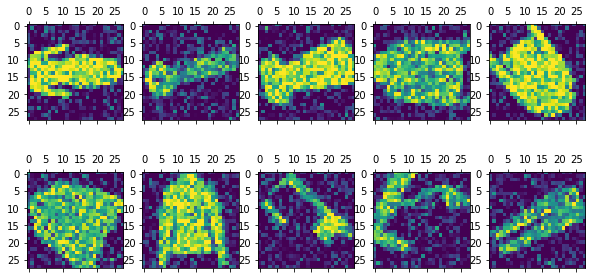

In [6]:
fig, ax = plt.subplots(2,5,figsize=(10, 5))

for item,a in zip(positive_image,ax.flat):
    c = a.matshow(item.reshape(28,28),interpolation ='nearest')

plt.show()

### 10 random negative class objects

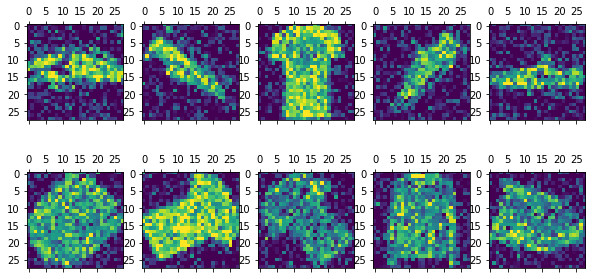

In [7]:
fig, ax = plt.subplots(2,5,figsize=(10, 5))

for item,a in zip(negative_image,ax.flat):
    c = a.matshow(item.reshape(28,28),interpolation ='nearest')

plt.show()

### ii. How many positive and negative examples are there in the training dataset?

In [8]:
print("Positive examples in training data: ",df[df.label == 1].shape[0])
print("Negative examples in training data: ",df[df.label == -1].shape[0])

Positive examples in training data:  2118
Negative examples in training data:  882


### iii. Which performance metric (accuracy, AUC-ROC and AUC-PR) should be used?

As our dataset is imbalanced, accuracy should not be used as a measure, as the target variable classes in the data are a majority of one class(1). Accuracy is a good measure when the target variable classes in the data are nearly balanced.
<br><br>
The AUC-ROC can be optimistic under a severe class imbalance, especially when the number of examples in the minority class is small. If both classes (1 and -1) are equally important, the AUC-ROC can be used. This will maximize the true positive rate and minimize the false positive rate.
<br><br>
AUC-PR focuses on the performance of the classifier based on the minority class. If the positive class is the most important, then the AUC-PR can be used. This will optimize both precision and recall across all thresholds.
<br><br>

As the data is heavily imbalanced we should use the <b>AUC-ROC</b> as the AUC-PR would reflect mostly the ability of prediction of the positive class and not the negative class which will naturally be harder to detect due to the imbalanced number of samples.

### iv. What is the expected accuracy of a random classifier (one that generates random labels for a given example) for this problem over the training and test datasets? Demonstrate why this would be the case.

Dummy Classifier will give an accuracy score around 0.50. Majority of the class labels are positive(1). A dummy classifier is a type of classifier which does not generate any insight about the data and classifies the given data using only simple rules. The classifier’s behavior is completely independent of the training data as the trends in the training data are completely ignored and instead uses one of the strategies(stratified) to predict the class label.

It is used only as a simple baseline for the other classifiers and it is especially useful for datasets where there is class imbalance.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

#splitting the training and testing data
Xtrain,Xtest,Ytrain,Ytest=train_test_split(xtrain,ytrain,test_size=0.5)

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(Xtrain, Ytrain)
Ypred = dummy_clf.predict(Xtest)
print("Accurcacy score of random classifier: ",round(dummy_clf.score(Ytest, Ypred),4))

Accurcacy score of random classifier:  0.5933


### v. What is the AUC-ROC and AUC-PR of a random classifier for this problem over the training and test datasets? Demonstrate why this would be the case.

The AUC-ROC will be around 0.50. AUC-ROC plot tests true positive rate(TPR) with respect to false positive rate(FPR) and as the classifier is random, a sample would be equally likely to be classified as positive regardless of whether it is truely positive or negative. Therefore, the TPR would always be the same as FPR. Therefore, AUC-ROC curve would be a line y=x. The AUC-ROC plot is shown below.

The AUC-PR will be around 0.80. AUC-PR plot tests Precision with respect to Recall. Recall will tell how much of that positive class you are actually guessing correct. Precision will tell how many you guessed positive that were not. (False Positives). 70% Recall would be bad as you're not guessing many of your imbalanced class, but perhaps 70% precision wouldn't be bad. The classifier gives better AUC-PR score as the data is heavily imbalanced. The curve for this plot (shown below) will be a straight line starting from top left corner to bottom right corner. The horizontal line represents that the Precision does not depend on Recall.

AUC-ROC of Dummy Classifier:  0.4914


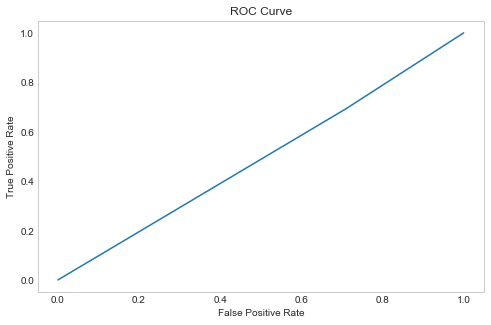

In [37]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

y_scores = dummy_clf.predict_proba(Xtest)
roc_score = roc_auc_score(Ytest,y_scores[:,1])

print("AUC-ROC of Dummy Classifier: ",round(roc_score,4))

fpr, tpr, _ = roc_curve(Ytest,y_scores[:,1])

#create ROC curve
plt.plot(fpr,tpr)
plt.title("ROC Curve")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.show()

AUC-PR of Dummy Classifier:  0.811


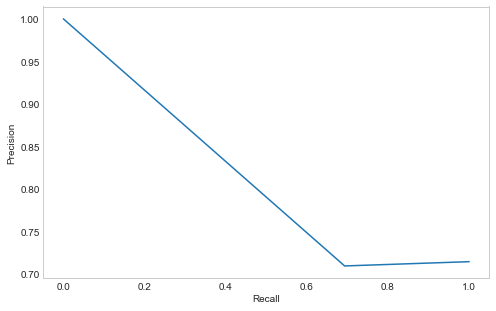

In [38]:
from sklearn.metrics import precision_recall_curve,auc

precision, recall, thresholds = precision_recall_curve(Ytest, y_scores[:,1])
auc_pr_score = auc(recall, precision)
print("AUC-PR of Dummy Classifier: ",round(auc_pr_score,4))
plt.plot(recall,precision)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.grid()
plt.show()

# Question No. 2: (Nearest Neighbor Classifier)

### i. What is the prediction accuracy, AUC-ROC and AUC-PR for each fold using this classifier? Show code to demonstrate the results.


In [39]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
# from sklearn.metrics import auc
from numpy import mean
from numpy import std

skf = StratifiedKFold(n_splits=5)

acc= list()
roc=list()
pr=list()
kNN_clf = KNeighborsClassifier(n_neighbors=1)
i=0

for train_index, test_index in skf.split(xtrain, ytrain):
    print("Fold = ",i+1)
    X_train, X_test = xtrain[train_index], xtrain[test_index]
    y_train, y_test = ytrain[train_index], ytrain[test_index]
    
    kNN_clf.fit(X_train, y_train)
    ypred = kNN_clf.predict(X_test)
    
    y_scores = kNN_clf.predict_proba(X_test)
    
    accuracy = accuracy_score(y_test, ypred)
    print("Accuracy Score: ",round(accuracy,4))
    acc.append(accuracy)
    
    
    roc_score = roc_auc_score(y_test,y_scores[:,1])
    print("AUC ROC score: ",round(roc_score,4))
    roc.append(roc_score)
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores[:,1])
    auc_pr_score = auc(recall, precision)
    print("AUC PR score: ",round(auc_pr_score,4))
    print()
    pr.append(auc_pr_score)
    
    fpr, tpr, _ = roc_curve(y_test,ypred,pos_label=1)
    
    
    #ROC curve    
#     axes[i,0].set_title("AUC-ROC for Fold- " + str(i+1))
#     axes[i,0].grid(True)
#     axes[i,0].plot(fpr,tpr)
#     axes[i,0].set_ylabel('True Positive Rate')
#     axes[i,0].set_xlabel('False Positive Rate')
   
#     # PR curve
#     axes[i,1].set_title("AUC-PR for Fold- " + str(i+1))
#     axes[i,1].grid(True)

#     axes[i,1].plot(recall,precision)
#     axes[i,1].set_ylabel('Precision')
#     axes[i,1].set_xlabel('Recall')
    i=i+1

plt.show()


Fold =  1
Accuracy Score:  0.74
AUC ROC score:  0.708
AUC PR score:  0.8869

Fold =  2
Accuracy Score:  0.76
AUC ROC score:  0.7322
AUC PR score:  0.8965

Fold =  3
Accuracy Score:  0.74
AUC ROC score:  0.713
AUC PR score:  0.8884

Fold =  4
Accuracy Score:  0.7383
AUC ROC score:  0.7126
AUC PR score:  0.8874

Fold =  5
Accuracy Score:  0.755
AUC ROC score:  0.7293
AUC PR score:  0.8944



### ii. What is the mean and standard deviation of each performance metric (accuracy, AUC-ROC and AUC-PR)across all the folds for this classifier? Show code to demonstrate the results.

In [13]:
# Calculating Mean of Accuracy, AUC-ROC and AUC-PR
print(" Mean Accuracy: ",round(mean(acc),4))
print(" Mean AUC-ROC: ",round(mean(roc),4))
print(" Mean AUC-PR: ",round(mean(pr),4))

# Calculating Standard Deviation of Accuracy, AUC-ROC and AUC-PR
print("\nStandard Deviation of Accuracy: ",round(statistics.stdev(acc),4))
print("Standard Deviation of AUC-ROC: ",round(statistics.stdev(roc),4))
print("Standard Deviation of AUC-PR : ",round(statistics.stdev(pr),4))

 Mean Accuracy:  0.7467
 Mean AUC-ROC:  0.719
 Mean AUC-PR:  0.8907

Standard Deviation of Accuracy:  0.0101
Standard Deviation of AUC-ROC:  0.0109
Standard Deviation of AUC-PR :  0.0044


### iii. What is the impact of various forms of pre-processing on the cross-validation performance? Show code to demonstrate the results.

#### 1. Standard Scaling


In [14]:
from sklearn import preprocessing
skf = StratifiedKFold(n_splits=5)
acc= list()
roc=list()
pr=list()
for train_index, test_index in skf.split(xtrain, ytrain):
    
    X_train, X_test = xtrain[train_index], xtrain[test_index]
    y_train, y_test = ytrain[train_index], ytrain[test_index]
    
    #transforming the training and testing data using Standard Scalar
    sc = preprocessing.StandardScaler().fit(X_train)
    xtrain_standardized = sc.transform(X_train)
    xtest_transformed = sc.transform(X_test)
    
    kNN_clf.fit(xtrain_standardized, y_train)
    y_scores = kNN_clf.predict_proba(xtest_transformed)
    ypred = kNN_clf.predict(xtest_transformed)
    
    # Calculating Scores
    accuracy = accuracy_score(y_test, ypred)
    roc_score = roc_auc_score(y_test,y_scores[:,1])
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores[:,1])
    auc_pr_score = auc(recall, precision)
    
    acc.append(accuracy)
    roc.append(roc_score)
    pr.append(auc_pr_score)
    
print(" Mean Accuracy: ",round(mean(acc),4))
print(" Mean AUC-ROC: ",round(mean(roc),4))
print(" Mean AUC-PR: ",round(mean(pr),4))

 Mean Accuracy:  0.7443
 Mean AUC-ROC:  0.7101
 Mean AUC-PR:  0.8877


#### 2. Min-Max Scaling

In [15]:
# Min max scaler
acc= list()
roc=list()
pr=list()

for train_index, test_index in skf.split(xtrain, ytrain):

    X_train, X_test = xtrain[train_index], xtrain[test_index]
    y_train, y_test = ytrain[train_index], ytrain[test_index]
    
    #transforming the training and testing data
    mm_scaler = preprocessing.MinMaxScaler().fit(X_train)
    xtrain_standardized = mm_scaler.transform(X_train)
    xtest_transformed = mm_scaler.transform(X_test)
    
    kNN_clf.fit(xtrain_standardized, y_train)
    ypred = kNN_clf.predict(xtest_transformed)
    y_scores = kNN_clf.predict_proba(xtest_transformed)
    
    # Calculating Scores
    accuracy = accuracy_score(y_test, ypred)
    roc_score = roc_auc_score(y_test,y_scores[:,1])
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores[:,1])
    auc_pr_score = auc(recall, precision)
    
    acc.append(accuracy)
    roc.append(roc_score)
    pr.append(auc_pr_score)
    
print(" Mean Accuracy: ",round(mean(acc),4))
print(" Mean AUC-ROC: ",round(mean(roc),4))
print(" Mean AUC-PR: ",round(mean(pr),4))

 Mean Accuracy:  0.7487
 Mean AUC-ROC:  0.7188
 Mean AUC-PR:  0.8909


#### 3. Robust Scaling

In [16]:
acc= list()
roc=list()
pr=list()
for train_index, test_index in skf.split(xtrain, ytrain):

    X_train, X_test = xtrain[train_index], xtrain[test_index]
    y_train, y_test = ytrain[train_index], ytrain[test_index]
    
    #transforming the training and testing data
    robust_scaler = preprocessing.RobustScaler().fit(X_train)
    xtrain_standardized = robust_scaler.transform(X_train)
    xtest_transformed = robust_scaler.transform(X_test)
    
    kNN_clf.fit(xtrain_standardized, y_train)
    ypred = kNN_clf.predict(xtest_transformed)
    y_scores = kNN_clf.predict_proba(xtest_transformed)
    
    # Calculating Scores
    accuracy = accuracy_score(y_test, ypred)
    roc_score = roc_auc_score(y_test,y_scores[:,1])
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores[:,1])
    auc_pr_score = auc(recall, precision)

    acc.append(accuracy)
    roc.append(roc_score)
    pr.append(auc_pr_score)
    
print(" Mean Accuracy: ",round(mean(acc),4))
print(" Mean AUC-ROC: ",round(mean(roc),4))
print(" Mean AUC-PR: ",round(mean(pr),4))

 Mean Accuracy:  0.7153
 Mean AUC-ROC:  0.6813
 Mean AUC-PR:  0.8756


#### 4. Normalization

In [17]:
# Normalization
acc= list()
roc=list()
pr=list()
for train_index, test_index in skf.split(xtrain, ytrain):

    X_train, X_test = xtrain[train_index], xtrain[test_index]
    y_train, y_test = ytrain[train_index], ytrain[test_index]
    
    #transforming the training and testing data
    normalizer = preprocessing.Normalizer().fit(X_train)
    xtrain_standardized = normalizer.transform(X_train)
    xtest_transformed = normalizer.transform(X_test)
    
    kNN_clf.fit(xtrain_standardized, y_train)
    ypred = kNN_clf.predict(xtest_transformed)
    y_scores = kNN_clf.predict_proba(xtest_transformed)

    # Calculating Scores
    accuracy = accuracy_score(y_test, ypred)
    roc_score = roc_auc_score(y_test,y_scores[:,1])
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores[:,1])
    auc_pr_score = auc(recall, precision)

    acc.append(accuracy)
    roc.append(roc_score)
    pr.append(auc_pr_score)
    
print(" Mean Accuracy: ",round(mean(acc),4))
print(" Mean AUC-ROC: ",round(mean(roc),4))
print(" Mean AUC-PR: ",round(mean(pr),4))

 Mean Accuracy:  0.762
 Mean AUC-ROC:  0.7054
 Mean AUC-PR:  0.8889


### Impact of various pre-processing methods on the cross-validation performance
| Preprocessing method | Accuracy | AUC-ROC score | AUC-PR score |
| --- | --- | --- | --- |
| Standard Scaler | 0.7443 | 0.7101 | 0.8877 |
| MinMax Scaler | 0.7487 | 0.7188 | 0.8909 |
| Robust Scaler | 0.7153 | 0.6813 | 0.8756 |
| Normalizer | 0.762 | 0.7054 | 0.8889 |

There is not much impact of these pre-processing techniques on the cross-validation performance. Overall, MinMax Scaler gives better performance compared to the others with AUC-ROC of 0.7188 and AUC-PR of 0.8909. 

### iv. Use 5-fold cross-validation over training data to calculate the optimal value of k for the k-Nearest neighbour classifier. What is the optimal value of k and what are the cross-validation accuracy, AUC-ROC and AUC-PR?

In [18]:
for i in range(1,11):
    knn_clf = KNeighborsClassifier(n_neighbors=i)
    acc = list()
    roc = list()
    pr = list()
    print("For value of k = ",i)
    for train_index, test_index in skf.split(xtrain, ytrain):

        X_train, X_test = xtrain[train_index], xtrain[test_index]
        y_train, y_test = ytrain[train_index], ytrain[test_index]
        
        mm_scaler = preprocessing.MinMaxScaler().fit(X_train)
        xtrain_scaled = mm_scaler.transform(X_train)
        xtest_scaled = mm_scaler.transform(X_test)
    
        knn_clf.fit(xtrain_scaled, y_train)
        ypred = knn_clf.predict(xtest_scaled)
        y_scores = knn_clf.predict_proba(xtest_scaled)
        
        # Calculating Scores
        accuracy = accuracy_score(y_test, ypred)
        roc_score = roc_auc_score(y_test,y_scores[:,1])
        precision, recall, thresholds = precision_recall_curve(y_test, y_scores[:,1])
        auc_pr_score = auc(recall, precision)

        acc.append(accuracy)
        roc.append(roc_score)
        pr.append(auc_pr_score)
    
    print(" Mean Accuracy: ",round(mean(acc),4))
    print(" Mean AUC-ROC: ",round(mean(roc),4))
    print(" Mean AUC-PR: ",round(mean(pr),4))
    print()

For value of k =  1
 Mean Accuracy:  0.7487
 Mean AUC-ROC:  0.7188
 Mean AUC-PR:  0.8909

For value of k =  2
 Mean Accuracy:  0.6787
 Mean AUC-ROC:  0.7547
 Mean AUC-PR:  0.8933

For value of k =  3
 Mean Accuracy:  0.7587
 Mean AUC-ROC:  0.7724
 Mean AUC-PR:  0.8959

For value of k =  4
 Mean Accuracy:  0.7223
 Mean AUC-ROC:  0.7752
 Mean AUC-PR:  0.8933

For value of k =  5
 Mean Accuracy:  0.7533
 Mean AUC-ROC:  0.7776
 Mean AUC-PR:  0.8931

For value of k =  6
 Mean Accuracy:  0.724
 Mean AUC-ROC:  0.7752
 Mean AUC-PR:  0.8906

For value of k =  7
 Mean Accuracy:  0.7583
 Mean AUC-ROC:  0.7806
 Mean AUC-PR:  0.8925

For value of k =  8
 Mean Accuracy:  0.7343
 Mean AUC-ROC:  0.7779
 Mean AUC-PR:  0.8901

For value of k =  9
 Mean Accuracy:  0.7517
 Mean AUC-ROC:  0.7772
 Mean AUC-PR:  0.8911

For value of k =  10
 Mean Accuracy:  0.7397
 Mean AUC-ROC:  0.778
 Mean AUC-PR:  0.8916



### Accuracy, AUC-ROC and AUC-PR for different values of k:
| k ↓ | Accuracy | AUC-ROC score | AUC-PR score |
| --- | --- | --- | --- |
|k=1| 0.7487 | 0.7188 | 0.8909 |
|k=2| 0.6787 | 0.7547 | 0.8933 |
|k=3| 0.7587 | 0.7724 | 0.8959 |
|k=4| 0.7223 | 0.7752 | 0.8933 |
|k=5| 0.7533 | 0.7776 | 0.8931 |
|k=6| 0.724 | 0.7752 | 0.8906 |
|k=7| 0.7583 | 0.7806 | 0.8925 |
|k=8| 0.7343 | 0.7779 | 0.8901 |
|k=9| 0.7517 | 0.7772 | 0.8911 |
|k=10| 0.7397 | 0.778 | 0.8916 |

#### Optimal Value of k is  7, as the AUC-ROC score is the highest which is 0.7806 . The AUC-PR is 0.8925 which almost equal to other AUC-PR scores for different values of k. For k=7, accuracy is also much better than others.

# Question No. 3: CV

### 1. Perceptron

In [19]:
# Grid Search Perceptron Code

from sklearn.linear_model import Perceptron
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

model = Perceptron()
cv = StratifiedKFold(n_splits=5)

# define grid
grid = dict()
grid['max_iter'] = [1, 10, 100, 1000]
grid['eta0'] = [0.0001, 0.001, 0.01, 0.1, 1.0]

# define search
grid = GridSearchCV(model, grid, cv=cv, scoring="roc_auc", n_jobs=-1)

# perform the search
results = grid.fit(xtrain, ytrain)

# summarize
print('Mean AUC-ROC Score: %.3f' % results.best_score_)
print('Best Parameters: %s' % results.best_params_)

# # summarize all
# mean_acc = results.cv_results_['mean_test_score']
# # mean_roc = results.cv_results_['mean_test_roc']

# params = results.cv_results_['params']
# for m, param in zip(means, params):
#     print("%.3f with: %r" % (m, param))

Mean AUC-ROC Score: 0.549
Best Parameters: {'eta0': 0.0001, 'max_iter': 10}


In [20]:
# Implementing Perceptron Classifier
from sklearn.linear_model import Perceptron

perceptron = Perceptron(eta0= 0.0001, max_iter=100)
cv = StratifiedKFold(n_splits=5)

acc= list()
roc=list()
pr=list()

for train_index, test_index in cv.split(xtrain, ytrain):
    X_train, X_test = xtrain[train_index], xtrain[test_index]
    y_train, y_test = ytrain[train_index], ytrain[test_index]
    
    perceptron.fit(X_train, y_train)
    ypred = perceptron.predict(X_test)
    y_scores = perceptron.decision_function(X_test)
    
    roc.append(roc_score)
    accuracy = accuracy_score(y_test, ypred)
    roc_score = roc_auc_score(y_test,y_scores)
    precision, recall, thresholds = precision_recall_curve(y_test,y_scores)
    auc_pr_score = auc(recall, precision)
    
    acc.append(accuracy)
    roc.append(roc_score)
    pr.append(auc_pr_score)
    
print(" Mean Accuracy: ",round(mean(acc),4))
print(" Mean AUC-ROC: ",round(mean(roc),4))
print(" Mean AUC-PR: ",round(mean(pr),4))

 Mean Accuracy:  0.6373
 Mean AUC-ROC:  0.5677
 Mean AUC-PR:  0.7346


### 2. Naive Bayes

In [40]:
from sklearn.naive_bayes import GaussianNB

nb_classifier = GaussianNB()
cv = StratifiedKFold(n_splits=5)

acc= list()
roc=list()
pr=list()

for train_index, test_index in cv.split(xtrain, ytrain):
    X_train, X_test = xtrain[train_index], xtrain[test_index]
    y_train, y_test = ytrain[train_index], ytrain[test_index]
    
    nb_classifier.fit(X_train, y_train)
    ypred = nb_classifier.predict(X_test)
    y_scores = nb_classifier.predict_proba(X_test)
    
    # Calculating Scores
    accuracy = accuracy_score(y_test, ypred)
    roc_score = roc_auc_score(y_test,y_scores[:,1])
    precision, recall, thresholds = precision_recall_curve(y_test,y_scores[:,1])
    auc_pr_score = auc(recall, precision)
    
    acc.append(accuracy)
    roc.append(roc_score)
    pr.append(auc_pr_score)
    
print(" Mean Accuracy: ",round(mean(acc),4))
print(" Mean AUC-ROC: ",round(mean(roc),4))
print(" Mean AUC-PR: ",round(mean(pr),4))

 Mean Accuracy:  0.5523
 Mean AUC-ROC:  0.5687
 Mean AUC-PR:  0.7682


### 3. Logistic Regression

In [22]:
# Logistics Regression GridSearch Code

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], "penalty":["l1","l2"],"max_iter":[500,600,1000]}

logreg = LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=cv,scoring="roc_auc")
results = logreg_cv.fit(xtrain,ytrain)

print('Mean AUC-ROC Score: %.3f' % results.best_score_)
print('Best Parameters: %s' % results.best_params_)

Mean AUC-ROC Score: 0.548
Best Parameters: {'C': 0.001, 'max_iter': 500, 'penalty': 'l2'}


In [23]:
from sklearn.linear_model import LogisticRegression

logistic_classifier = LogisticRegression(C=0.001, max_iter=500)

cv = StratifiedKFold(n_splits=5)

acc= list()
roc=list()
pr=list()

for train_index, test_index in cv.split(xtrain, ytrain):
    X_train, X_test = xtrain[train_index], xtrain[test_index]
    y_train, y_test = ytrain[train_index], ytrain[test_index]
    
    logistic_classifier.fit(X_train, y_train)
    ypred = logistic_classifier.predict(X_test)
    y_scores = logistic_classifier.predict_proba(X_test)
    
    # Calculating Scores
    accuracy = accuracy_score(y_test, ypred)
    roc_score = roc_auc_score(y_test,y_scores[:,1])
    precision, recall, thresholds = precision_recall_curve(y_test,y_scores[:,1])
    auc_pr_score = auc(recall, precision)
    
    acc.append(accuracy)
    roc.append(roc_score)
    pr.append(auc_pr_score)
    
print(" Mean Accuracy: ",round(mean(acc),4))
print(" Mean AUC-ROC: ",round(mean(roc),4))
print(" Mean AUC-PR: ",round(mean(pr),4))

 Mean Accuracy:  0.6117
 Mean AUC-ROC:  0.5478
 Mean AUC-PR:  0.7433


### 4. Linear SVM

In [24]:
# Linear SVM GridSearch Code
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import svm
import numpy as np
xtrain = np.loadtxt("Xtrain.csv")
ytrain = np.loadtxt("Ytrain.csv")
xtest = np.loadtxt("Xtest.csv")

svm_classifier = svm.LinearSVC()
param_grid = {'max_iter':[100,500,1000,2000],'C': [0.001,0.1,1,10]}

#scaling the data
mm_scaler = preprocessing.MinMaxScaler().fit(xtrain)
xtrain_standardized = mm_scaler.transform(xtrain)

grid = GridSearchCV(svm_classifier, param_grid,cv=cv, scoring="roc_auc",n_jobs=2)

# fitting the model for grid search
results = grid.fit(xtrain_standardized, ytrain)

# print("tuned hyperparameters :(best parameters) ",logreg_cv.best_params_)
# print("accuracy :",logreg_cv.best_score_)

# summarize
print('Mean AUC-ROC Score: %.3f' % results.best_score_)
print('Best Parameters: %s' % results.best_params_)

Mean AUC-ROC Score: 0.585
Best Parameters: {'C': 0.001, 'max_iter': 500}


In [25]:
# Linear SVM
from sklearn import svm

svm_classifier = svm.LinearSVC(max_iter=1000,C=0.001)

cv = StratifiedKFold(n_splits=5)

acc= list()
roc=list()
pr=list()

mm_scaler = preprocessing.MinMaxScaler().fit(xtrain)
xtrain_scaled = mm_scaler.transform(xtrain)

for train_index, test_index in cv.split(xtrain_scaled, ytrain):
    X_train, X_test = xtrain_scaled[train_index], xtrain_scaled[test_index]
    y_train, y_test = ytrain[train_index], ytrain[test_index]
    
    svm_classifier.fit(X_train, y_train)
    ypred = svm_classifier.predict(X_test)
    
    y_scores = svm_classifier.decision_function(X_test)
    
    accuracy = accuracy_score(y_test, ypred)
    roc_score = roc_auc_score(y_test,y_scores)
    precision, recall, thresholds = precision_recall_curve(y_test,y_scores)
    
    auc_pr_score = auc(recall, precision)
    acc.append(accuracy)
    roc.append(roc_score)
    pr.append(auc_pr_score)
    
print(" Mean Accuracy: ",round(mean(acc),4))
print(" Mean AUC-ROC: ",round(mean(roc),4))
print(" Mean AUC-PR: ",round(mean(pr),4))

 Mean Accuracy:  0.7033
 Mean AUC-ROC:  0.5848
 Mean AUC-PR:  0.7634


### 5. Kernalized SVM

In [26]:
# SVM GridSearch Code
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import svm

svm_classifier = svm.SVC()
param_grid = {'max_iter':[100,500,1000,2000],'C': [0.001,0.1,1,10],'kernel':['rbf','sigmoid'],'degree': [1],'gamma': [0.01,0.1,1,10]}

#scaling the data
mm_scaler = preprocessing.MinMaxScaler().fit(xtrain)
xtrain_standardized = mm_scaler.transform(xtrain)

grid = GridSearchCV(svm_classifier, param_grid,cv=cv, scoring="roc_auc",n_jobs=-1)

# fitting the model for grid search
results = grid.fit(xtrain_standardized, ytrain)

# print("tuned hyperparameters :(best parameters) ",logreg_cv.best_params_)
# print("accuracy :",logreg_cv.best_score_)

# summarize
print('Mean AUC-ROC Score: %.3f' % results.best_score_)
print('Best Parameters: %s' % results.best_params_)

Mean AUC-ROC Score: 0.789
Best Parameters: {'C': 10, 'degree': 1, 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': 1000}


In [27]:
# Kernalized SVM
svm_classifier = svm.SVC(max_iter=1000, C=10, gamma=0.1, kernel='rbf',probability=True)

cv = StratifiedKFold(n_splits=5)

acc= list()
roc=list()
pr=list()

mm_scaler = preprocessing.MinMaxScaler().fit(xtrain)
xtrain_scaled = mm_scaler.transform(xtrain)

for train_index, test_index in cv.split(xtrain_scaled, ytrain):
    X_train, X_test = xtrain_scaled[train_index], xtrain_scaled[test_index]
    y_train, y_test = ytrain[train_index], ytrain[test_index]
    
    svm_classifier.fit(X_train, y_train)
    ypred = svm_classifier.predict(X_test)
    y_scores = svm_classifier.predict_proba(X_test)
    
    # Calculation Scores
    accuracy = accuracy_score(y_test, ypred)
    roc_score = roc_auc_score(y_test,y_scores[:,1])
    precision, recall, thresholds = precision_recall_curve(y_test,y_scores[:,1])
    auc_pr_score = auc(recall, precision)

    acc.append(accuracy)
    roc.append(roc_score)
    pr.append(auc_pr_score)
    
print(" Mean Accuracy: ",round(mean(acc),4))
print(" Mean AUC-ROC: ",round(mean(roc),4))
print(" Mean AUC-PR: ",round(mean(pr),4))

print("\nStandard Deviation of Accuracy: ",round(statistics.stdev(acc),4))
print("Standard Deviation of AUC-ROC: ",round(statistics.stdev(roc),4))
print("Standard Deviation of AUC-PR : ",round(statistics.stdev(pr),4))

 Mean Accuracy:  0.7137
 Mean AUC-ROC:  0.7885
 Mean AUC-PR:  0.8877

Standard Deviation of Accuracy:  0.004
Standard Deviation of AUC-ROC:  0.0102
Standard Deviation of AUC-PR :  0.0151


###  Classifiers comparison
| Classifier | Accuracy | AUC-ROC score | AUC-PR score |
| --- | --- | --- | --- |
| k Nearest Neighbour | 0.7583 | 0.7806 | 0.8925 |
| Percertron | 0.6373 | 0.5677 | 0.7346 |
| Naive Bayes | 0.5523 | 0.5687 | 0.7682 |
| Logistic Regression | 0.6117 | 0.5478 | 0.7433 |
| Linear SVM | 0.7033 | 0.5848 | 0.7634 |
| Kernalized SVM | 0.7137 | 0.7885 | 0.8877 |

#### Best Model is Kernalized SVM with the following mean and standard deviation values:
<br>
Parameter setting: max_iter=1000, C=10, gamma=0.1, kernel='rbf'<br>

Mean Accuracy:  0.7137<br>
Mean AUC-ROC:  0.7885<br>
Mean AUC-PR:  0.8877<br>
<br>
Standard Deviation of Accuracy:  0.004<br>
Standard Deviation of AUC-ROC:  0.0102<br>
Standard Deviation of AUC-PR :  0.0151<br>

# Question No. 4 PCA

### i. Reduce the number of dimensions of the data using PCA to 2 and plot a scatter plot of the training data. What are your observations about the data based on data?

In [28]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(xtrain)

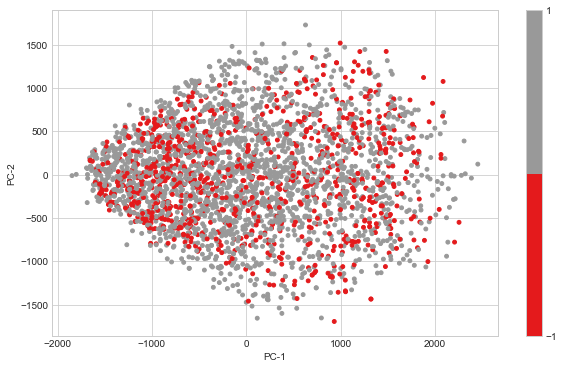

In [29]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (10,6))
c_map = plt.cm.get_cmap('Set1', 2)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], s = 15,cmap = c_map , c = ytrain)
plt.colorbar(ticks=[1,-1])
plt.xlabel('PC-1') , plt.ylabel('PC-2')
plt.show()

### From above graph it can be said that the two components are not enough to separate the data and it is highly correlated. The data is scattered and do not form clusters.

### ii. Plot the scree graph of PCA and find the number of dimensions that explain 95% variance in the training set. 

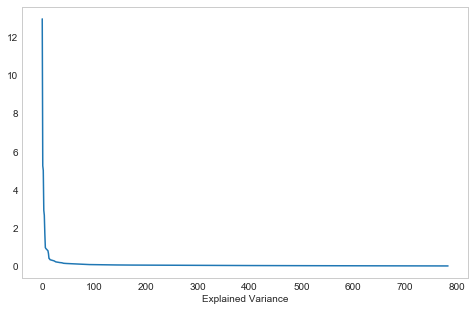

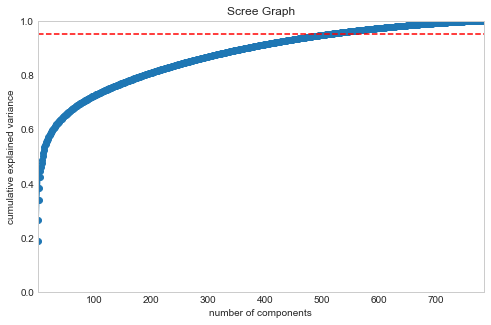

In [30]:
import matplotlib.pyplot as plt
scaler = preprocessing.MinMaxScaler()
data_rescaled = scaler.fit_transform(xtrain)
pca = PCA(n_components=784)
plt.rcParams["figure.figsize"] = (8,5)
X_train_pca = pca.fit_transform(data_rescaled)
plt.plot(pca.explained_variance_)
# plt.axis('tight')
plt.grid()
plt.xlabel('Explained Variance')
plt.figure()
plt.plot(np.arange(len(pca.explained_variance_ratio_))+1,np.cumsum(pca.explained_variance_ratio_),'o-') #plot the scree graph
plt.axis([1,len(pca.explained_variance_ratio_),0,1])
plt.axhline(y=0.95,color='r',linestyle='--')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.title('Scree Graph')
plt.grid()
plt.show()

In [31]:
pca_var=PCA(0.95)
pca_var.fit(data_rescaled)
print(pca_var.n_components_)

512


### As seen from the scree graph above, 2 Principal Components are not enough to represent the 95% variance. The number of dimensions that explain 95 % of the variance in training set is 512.

### iii. Reduce the number of dimensions of the data using PCA and perform classification. What is the (optimal) cross-validation performance of a Kernelized SVM classification with PCA?


In [32]:
mm_scaler = preprocessing.MinMaxScaler().fit(xtrain)
xtrain_scaled = mm_scaler.transform(xtrain)

pca = PCA(n_components=512)
X_train_pca = pca.fit_transform(xtrain_scaled)

In [33]:
from sklearn import svm

svm_classifier = svm.SVC(max_iter=1000,C=10, gamma=0.1, kernel='rbf',probability=True)

cv = StratifiedKFold(n_splits=5)

acc= list()
roc=list()
pr=list()

for train_index, test_index in cv.split(X_train_pca, ytrain):
    X_train, X_test = X_train_pca[train_index], X_train_pca[test_index]
    y_train, y_test = ytrain[train_index], ytrain[test_index]
    
    svm_classifier.fit(X_train, y_train)
    ypred = svm_classifier.predict(X_test)
    
    y_scores = svm_classifier.predict_proba(X_test)
    
    accuracy = accuracy_score(y_test, ypred)
#     print("Accuracy Score: ",accuracy)
    acc.append(accuracy)
    
    
    roc_score = roc_auc_score(y_test,y_scores[:,1])
#     print("AUC ROC score: ",roc_score)
    roc.append(roc_score)
    
    precision, recall, thresholds = precision_recall_curve(y_test,y_scores[:,1])
    auc_pr_score = auc(recall, precision)
#     print("AUC PR score: ",auc_pr_score)
    pr.append(auc_pr_score)
    
print(" Mean Accuracy: ",round(mean(acc),4))
print(" Mean AUC-ROC: ",round(mean(roc),4))
print(" Mean AUC-PR: ",round(mean(pr),4))

 Mean Accuracy:  0.7197
 Mean AUC-ROC:  0.794
 Mean AUC-PR:  0.8894


### The optimal cross-validation performance of a Kernelized SVM classification with PCA gives <br> AUC-ROC of 0.794 and AUC-PR of 0.8894.

# Question No. 5

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

xtest = np.loadtxt("Xtest.csv")
steps = [('scaler', preprocessing.MinMaxScaler()),('PCA',PCA(n_components=512)),('SVM', SVC(max_iter=1000,C=10, gamma=0.1, kernel='rbf'))]
pipeline = Pipeline(steps)
pipeline.fit(xtrain, ytrain)

y_pred = pipeline.predict(xtest)
y_pred_proba = pipeline.decision_function(xtest)

In [35]:
#creating the file to store 
f= open("u2160197.csv","w+")

for i in range(len(y_pred_proba)):
     f.write("%s\n" % (y_pred_proba[i])) 
        
f.close()

In [36]:
# print(np.count_nonzero(y_pred==1))
# print(np.count_nonzero(y_pred==-1))